In [1]:
import pandas as pd
import numpy as np
from statsmodels import regression
import statsmodels.api as sm
import matplotlib.pyplot as plt
import math
%matplotlib inline

## Initial Data

In [2]:
data = pd.read_excel('to saketh.xlsx')
data.head()

,crsp_cl_grp,year,quarter,dollar_flows (t),psi (t-1),sigma (t),r (t)
0,2002603,2000,1,34.97290,2.742498,24.31458,-1.528390
1,2002603,2000,2,40.79236,0.938819,28.88293,-1.767076
2,2002603,2000,3,32.78430,0.734990,15.19339,-5.368132
3,2002603,2000,4,34.54834,0.881965,27.46894,-1.682085
4,2002603,2001,1,30.53607,0.888824,25.67295,-17.174280


## Datat Manipulation

In [3]:
psi = data['psi (t-1)']
delta_q = data['dollar_flows (t)']
sigma_t = data['sigma (t)']
r_t = data['r (t)']
r_t1 = r_t.shift(periods=-1, axis='rows')
r_t1.pop(67)
delta_q1 = delta_q.shift(periods=-1, axis='rows')
delta_q1.pop(67)
sigma_t1 = sigma_t.shift(periods=-1, axis='rows')
sigma_t1.pop(67)
sigmasquare_t1 = sigma_t1**2
sigma_t.pop(67)
sigmasquare_t = sigma_t**2

In [4]:
new_data = pd.DataFrame(delta_q1)
new_data['r_t1'] = r_t1
new_data['psi'] = psi
new_data['sigmasquare_t1'] = sigmasquare_t1
new_data['sigmasquare_t'] = sigmasquare_t
new_data.head()

,dollar_flows (t),r_t1,psi,sigmasquare_t1,sigmasquare_t
0,40.79236,-1.767076,2.742498,834.223645,591.198801
1,32.78430,-5.368132,0.938819,230.839100,834.223645
2,34.54834,-1.682085,0.734990,754.542665,230.839100
3,30.53607,-17.174280,0.881965,659.100362,754.542665
4,15.07355,3.692329,0.888824,504.837537,659.100362


In [5]:
eta = 1

## $Y$ = $\frac{\Delta q_{t+1}}{\eta r_{t+1}}$ - $\frac{\psi_t}{r_{t+1}}$$(\sigma_{t+1}^2-\sigma_t^2)$

In [6]:
new_data['Y'] = (new_data['dollar_flows (t)']/(new_data['r_t1'])*eta) - (new_data['psi']/new_data['r_t1'])*(new_data['sigmasquare_t1']-new_data['sigmasquare_t']) 

## New DataSet

In [7]:
new_data.head()

,dollar_flows (t),r_t1,psi,sigmasquare_t1,sigmasquare_t,Y
0,40.79236,-1.767076,2.742498,834.223645,591.198801,354.089349
1,32.78430,-5.368132,0.938819,230.839100,834.223645,-111.631602
2,34.54834,-1.682085,0.734990,754.542665,230.839100,208.294321
3,30.53607,-17.174280,0.881965,659.100362,754.542665,-6.679339
4,15.07355,3.692329,0.888824,504.837537,659.100362,41.216809


In [8]:
Y_t1 = new_data['Y']

# Plot

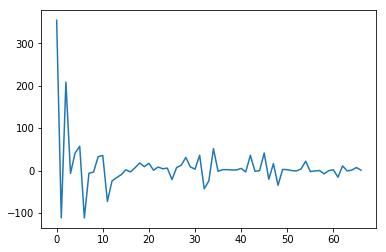

In [9]:
plt.plot(Y_t1)

### OLS Regression

In [10]:
X = sm.add_constant(sigmasquare_t)
model = regression.linear_model.OLS(Y_t1, X).fit()

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [11]:
intercept = model.params[0]

In [12]:
coefficent = model.params[1]

In [13]:
print('intercept:',intercept,'coefficent:',coefficent)

intercept: 8.635399184215675 coefficent: -0.0008973154720135824


In [14]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.015
Method:                 Least Squares   F-statistic:                  0.005303
Date:                Mon, 19 Aug 2019   Prob (F-statistic):              0.942
Time:                        12:10:16   Log-Likelihood:                -365.94
No. Observations:                  67   AIC:                             735.9
Df Residuals:                      65   BIC:                             740.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.6354      8.599      1.004      0.3

$B = \sigma_{t+1}^2$

In [15]:
B = new_data.sigmasquare_t1

## Kalman Filtering

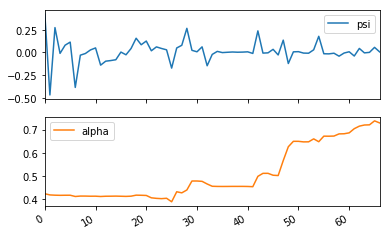

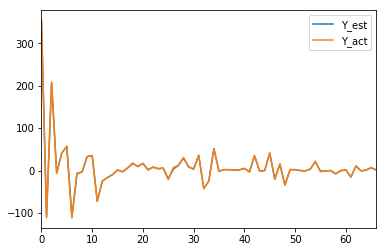

In [16]:
from pykalman import KalmanFilter

if __name__ == "__main__":
    delta = 1e-3
    trans_cov = delta / (1 - delta) * np.eye(2)
    obs_mat = np.vstack( [B,  np.ones(B.shape)]).T[:, np.newaxis]
    kf = KalmanFilter(
        n_dim_obs=1,
        n_dim_state=2,
        initial_state_mean=np.zeros(2),
        initial_state_covariance=np.ones((2, 2)),
        transition_matrices=np.eye(2),
        observation_matrices=obs_mat,
        observation_covariance=1.0,
        transition_covariance=trans_cov        
    )

    state_means, state_covs = kf.filter(Y_t1)


    
    Y_est = np.array([a.dot(b) for a, b in zip(np.squeeze(obs_mat), state_means)])

    # Draw slope and intercept...
    pd.DataFrame(
        dict(
            psi=state_means[:, 0],
            alpha=state_means[:, 1],
        ), index=Y_t1.index
    ).plot(subplots=True)
    plt.show()

    pd.DataFrame(
        dict(
            Y_est=Y_est,
            Y_act=Y_t1
        ), index=Y_t1.index
    ).plot()
    plt.show()

In [17]:
from sklearn.metrics import mean_squared_error

In [18]:
mean_squared_error(Y_t1, Y_est)

0.8166273896916041

In [19]:
MSE = np.square(np.subtract(Y_t1,Y_est)).mean() 

## Mean Squared Error

In [20]:
MSE

0.8166273896916039